In [ ]:
import gym
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from google.colab import files
import math
import random
import time
import numpy as np

In [ ]:
!pip install kaggle_environments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_

In [ ]:
from kaggle_environments import evaluate, make, utils
env = make("connectx", debug=True)
agent1 = 'random'
agent2 = 'negamax'

env.run([agent1, agent2])
env.render(mode="ipython", width=600, height=500, header=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = 'drive/MyDrive/RL/'


#MCTS

In [ ]:
def MCTS_agent(observation, configuration):
    """
    Connect X agent based on MCTS.
    """
    import random
    import math
    import time
    global current_state  # so tree can be recycled

    init_time = time.time()
    EMPTY = 0
    T_max = configuration.timeout - 0.34  # time per move, left some overhead
    Cp_default = 1

    def play(board, column, mark, config):
        """ Plays a move. Taken from the Kaggle environment. """
        columns = config.columns
        rows = config.rows
        row = max([r for r in range(rows) if board[column + (r * columns)] == EMPTY])
        board[column + (row * columns)] = mark

    def is_win(board, column, mark, config):
        """ Checks for a win. Taken from the Kaggle environment. """
        columns = config.columns
        rows = config.rows
        inarow = config.inarow - 1
        row = min([r for r in range(rows) if board[column + (r * columns)] == mark])

        def count(offset_row, offset_column):
            for i in range(1, inarow + 1):
                r = row + offset_row * i
                c = column + offset_column * i
                if (
                        r < 0
                        or r >= rows
                        or c < 0
                        or c >= columns
                        or board[c + (r * columns)] != mark
                ):
                    return i - 1
            return inarow

        return (
                count(1, 0) >= inarow  # vertical.
                or (count(0, 1) + count(0, -1)) >= inarow  # horizontal.
                or (count(-1, -1) + count(1, 1)) >= inarow  # top left diagonal.
                or (count(-1, 1) + count(1, -1)) >= inarow  # top right diagonal.
        )

    def is_tie(board):
        """ Checks if a tie occured. """
        return not(any(mark == EMPTY for mark in board))

    def check_finish_and_score(board, column, mark, config):
        """ Returns a tuple where the first argument states whether game is finished and second argument returns score if game has finished. """
        if is_win(board, column, mark, config):
            return (True, 1)
        if is_tie(board):
            return (True, 0.5)
        else:
            return (False, None)

    def uct_score(node_total_score, node_total_visits, parent_total_visits, Cp=Cp_default):
        """ UCB1 calculation. """
        if node_total_visits == 0:
            return math.inf
        return node_total_score / node_total_visits + Cp * math.sqrt(
            2 * math.log(parent_total_visits) / node_total_visits)

    def opponent_mark(mark):
        """ The mark indicates which player is active - player 1 or player 2. """
        return 3 - mark

    def opponent_score(score):
        """ To backpropagate scores on the tree. """
        return 1 - score

    def random_action(board, config):
        """ Returns a random legal action (from the open columns). """
        return random.choice([c for c in range(config.columns) if board[c] == EMPTY])

    def default_policy_simulation(board, mark, config):
        """
        Run a random play simulation. Starting state is assumed to be a non-terminal state.
        Returns score of the game for the player with the given mark.
        """
        original_mark = mark
        board = board.copy()
        column = random_action(board, config)
        play(board, column, mark, config)
        is_finish, score = check_finish_and_score(board, column, mark, config)
        while not is_finish:
            mark = opponent_mark(mark)
            column = random_action(board, config)
            play(board, column, mark, config)
            is_finish, score = check_finish_and_score(board, column, mark, config)
        if mark == original_mark:
            return score
        return opponent_score(score)

    def find_action_taken_by_opponent(new_board, old_board, config):
        """ Given a new board state and a previous one, finds which move was taken. Used for recycling tree between moves. """
        for i, piece in enumerate(new_board):
            if piece != old_board[i]:
                return i % config.columns
        return -1  # shouldn't get here

    class State():
        """
        A class that represents nodes in the game tree.

        """
        def __init__(self, board, mark, config, parent=None, is_terminal=False, terminal_score=None, action_taken=None):
            self.board = board.copy()
            self.mark = mark
            self.config = config
            self.children = []
            self.parent = parent
            self.node_total_score = 0
            self.node_total_visits = 0
            self.available_moves = [c for c in range(config.columns) if board[c] == EMPTY]
            self.expandable_moves = self.available_moves.copy()
            self.is_terminal = is_terminal
            self.terminal_score = terminal_score
            self.action_taken = action_taken

        def is_expandable(self):
            """ Checks if the node has unexplored children. """
            return (not self.is_terminal) and (len(self.expandable_moves) > 0)

        def expand_and_simulate_child(self):
            """ Expands a random move from the legal unexplored moves, and runs a simulation of it
            (Expansion + Simulation + Backpropagation stages in the MCTS algorithm description). """
            column = random.choice(self.expandable_moves)
            child_board = self.board.copy()
            play(child_board, column, self.mark, self.config)
            is_terminal, terminal_score = check_finish_and_score(child_board, column, self.mark, self.config)
            self.children.append(State(child_board, opponent_mark(self.mark),
                                       self.config, parent=self,
                                       is_terminal=is_terminal,
                                       terminal_score=terminal_score,
                                       action_taken=column
                                       ))
            simulation_score = self.children[-1].simulate()
            self.children[-1].backpropagate(simulation_score)
            self.expandable_moves.remove(column)

        def choose_strongest_child(self, Cp):
            """
            Chooses child that maximizes UCB1 score (Selection stage in the MCTS algorithm description).
            """
            children_scores = [uct_score(child.node_total_score,
                                         child.node_total_visits,
                                         self.node_total_visits,
                                         Cp) for child in self.children]
            max_score = max(children_scores)
            best_child_index = children_scores.index(max_score)
            return self.children[best_child_index]

        def choose_play_child(self):
            """ Choose child with maximum total score."""
            children_scores = [child.node_total_score for child in self.children]
            try:
              max_score = max(children_scores)
              best_child_index = children_scores.index(max_score)
              return self.children[best_child_index]
            except:
              self.action_taken = 0
              return self
        def tree_single_run(self):
            """
            A single iteration of the 4 stages of the MCTS algorithm.
            """
            if self.is_terminal:
                self.backpropagate(self.terminal_score)
                return
            if self.is_expandable():
                self.expand_and_simulate_child()
                return
            self.choose_strongest_child(Cp_default).tree_single_run()

        def simulate(self):
            """
            Runs a simulation from the current state.
            This method is used to simulate a game after move of current player, so if a terminal state was reached,
            the score would belong to the current player who made the move.
            But otherwise the score received from the simulation run is the opponent's score and thus needs to be flipped with the function opponent_score().
            """
            if self.is_terminal:
                return self.terminal_score
            return opponent_score(default_policy_simulation(self.board, self.mark, self.config))

        def backpropagate(self, simulation_score):
            """
            Backpropagates score and visit count to parents.
            """
            self.node_total_score += simulation_score
            self.node_total_visits += 1
            if self.parent is not None:
                self.parent.backpropagate(opponent_score(simulation_score))

        def choose_child_via_action(self, action):
            """ Choose child given the action taken from the state. Used for recycling of tree. """
            for child in self.children:
                if child.action_taken == action:
                    return child
            return None

    board = observation.board
    mark = observation.mark

    # If current_state already exists, recycle it based on action taken by opponent
    try:
        current_state = current_state.choose_child_via_action(
            find_action_taken_by_opponent(board, current_state.board, configuration))
        current_state.parent = None  # make current_state the root node, dereference parents and siblings

    except:  # new game or other error in recycling attempt due to Kaggle mechanism
        current_state = State(board, mark,  # This state is considered after the opponent's move
                              configuration, parent=None, is_terminal=False, terminal_score=None, action_taken=None)

    # Run MCTS iterations until time limit is reached.
    c = 0
    while time.time() - init_time <= T_max and c<=thr:
        c+=1
        current_state.tree_single_run()
    print(time.time() - init_time )
    current_state = current_state.choose_play_child()
    return current_state.action_taken

In [ ]:
#MCTS vs random
m1,m2  = [0,0,0],[0,0,0] #[wins, draws, losses]

def compete(agent1,agent2,m):
  env.reset()
  original_stdout = sys.stdout
  sys.stdout = open('/dev/null', 'w')
  env.run([agent1,agent2])
  sys.stdout = original_stdout
  r1,r2 = env.state[0]['reward'],env.state[1]['reward']
  if r1 == 1:
    m[0] += 1
  elif r2 == 1:
    m[1] += 1
  else:
    m[2] += 1
  return m
thr = 100
for i in tqdm(range(100)):
  m1 = compete(MCTS_agent,'negamax',m1)
  m2 = compete('negamax',MCTS_agent,m2)



In [1]:
print(m1,m2) #[96,0,4],[0,100,0]

[96, 0, 4] [0, 100, 0]


In [ ]:
env.configuration

{'episodeSteps': 1000,
 'actTimeout': 2,
 'runTimeout': 1200,
 'columns': 7,
 'rows': 6,
 'inarow': 4,
 'agentTimeout': 60,
 'timeout': 2}

In [ ]:
#Creating agent from a neural network to test in kaggle environment
class neur_net_agent:
  def __init__(self,net):
    self.net = net
  def check_inv(self,s,a):
    t = s.T
    for i in t[a]:
      if i ==0:
        return False
    return True
  def __call__(self,observation,configuration):
    s = np.array(observation['board']).reshape((1,6,7))
    s[s==2] = -1

    q = self.net.predict(s,verbose = 0)
    a = np.argmax(q[0])
    s = s.reshape(6,7)
    while self.check_inv(s,a):
      q[0][a] = -np.inf
      a = np.argmax(q[0])
    return int(a)

In [ ]:
import keras

In [2]:
# # !pip install --upgrade keras

model1 = keras.models.load_model('CNN_custom_8_valid.keras')

In [ ]:
cnn_self = neur_net_agent(model1)

In [3]:
#MCTS(100) vs cnn_custom
m1,m2  = [0,0,0],[0,0,0] #[wins, draws, losses]

def compete(agent1,agent2,m):
  env.reset()
  # original_stdout = sys.stdout
  # sys.stdout = open('/dev/null', 'w')
  env.run([agent1,agent2])
  # sys.stdout = original_stdout
  r1,r2 = env.state[0]['reward'],env.state[1]['reward']
  if r1 == 1:
    m[0] += 1
  elif r2 == 1:
    m[1] += 1
  else:
    m[2] += 1
  return m

for i in tqdm(range(100)):
  m1 = compete(MCTS_agent,cnn_self,m1)
  m2 = compete(cnn_self,MCTS_agent,m2)
sys.stdout = original_stdout
print((m1+m2)/2) # MCTS : 100, [88,7,5]

[88, 7, 5]


In [4]:
#MCTS(50) vs cnn_custom
m1,m2 = [0,0,0],[0,0,0]
for i in tqdm(range(100)):
  m1 = compete(cnn_self,MCTS_agent,m1)
  m2 = compete(MCTS_agent,cnn_self,m2)

print((m1+m2)/2) # MCTS : 50, [68.5,16.5,15]

[68.5, 16.5, 15]


In [6]:
#MCTS(25) vs cnn_custom
m1,m2 = [0,0,0],[0,0,0]
for i in tqdm(range(100)):
  m1 = compete(cnn_self,MCTS_agent,m1)
  m2 = compete(MCTS_agent,cnn_self,m2)

print((m1+m2)/2) # MCTS : 25, [57,27,16]

[57, 27, 16]


In [8]:
#MCTS(10) vs cnn_custom
m1,m2 = [0,0,0],[0,0,0]
for i in tqdm(range(100)):
  m1 = compete(cnn_self,MCTS_agent,m1)
  m2 = compete(MCTS_agent,cnn_self,m2)

print((m1+m2)/2) # MCTS : 10, [40,56,4]

[40, 56, 4]


In [ ]:
m2 = [0,0,0] #CNN 2000 vs MCTS 25
for i in tqdm(range(100)):
  m2 = compete(MCTS_agent,cnn_self,m2)

print(m2) # MCTS 25 [59,29,12]

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

[59, 29, 12]


In [ ]:
m2 = [0,0,0] #CNN 2000 vs MCTS 10
for i in tqdm(range(100)):
  m2 = compete(MCTS_agent,cnn_self,m2)

print(m2) # MCTS 10 [49,47,4]

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]

[55, 40, 5]


In [ ]:
def compete(agent1,agent2,m):
  env.reset()
  original_stdout = sys.stdout
  # sys.stdout = open('/dev/null', 'w')
  env.run([agent1,agent2])
  # sys.stdout = original_stdout
  r1,r2 = env.state[0]['reward'],env.state[1]['reward']
  if r1 == 1:
    m[0] += 1
  elif r2 == 1:
    m[1] += 1
  else:
    m[2] += 1
  return m
def plot_mcts(agent):
  mcts = [5,10,12,15,17,20,25,50,75,100]
  wins = []
  global thr
  for i in mcts:
    thr = i
    m1,m2 = [0,0,0],[0,0,0]
    for j in tqdm(range(100)):
      m1 = compete(MCTS_agent,agent,m1)
      m2 = compete(agent,MCTS_agent,m2)
    wins.append((m1[1]+m2[0])/2)

  plt.plot(mcts, wins, marker='o', linestyle='-')

  # Display y-axis values at the points
  for i, txt in enumerate(wins):
      plt.annotate(txt, (mcts[i], wins[i]), textcoords="offset points", xytext=(0,10), ha='center')

  # Add labels to the axes
  plt.xlabel('Number of iterations')
  plt.ylabel('Percentage wins by agent')
  plt.title('Win percentage by {} against MCTS'.format(str(agent)))
  # Show the plot
  plt.grid(True)
  plt.show()

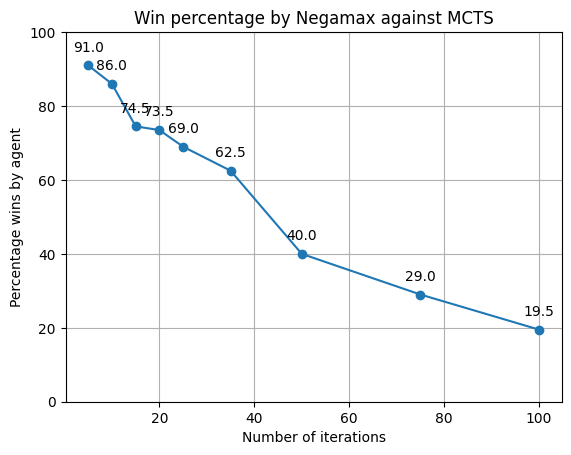

In [ ]:
plot_mcts('negamax')

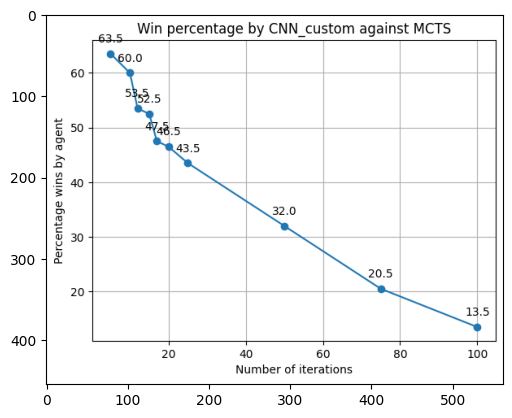

In [12]:
plot_mcts(cnn_self)

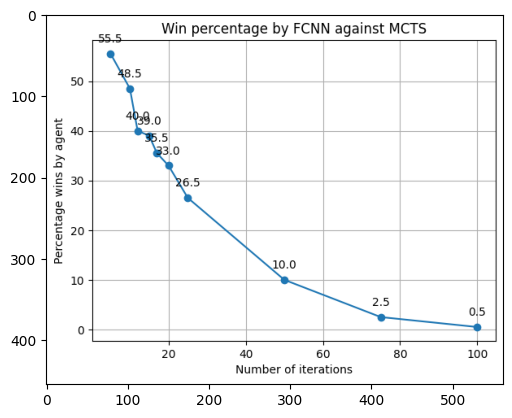

In [14]:
plot_mcts(fcnn_self)

## Minimax

In [ ]:
def my_agent(obs, config):
    # Your code here: Amend the agent!
    import random
    import numpy as np
    import time

    start = time.time()

    def drop_piece(grid, col, mark, config):
        next_grid = grid.copy()
        for row in range(config.rows-1, -1, -1):
            if next_grid[row][col]==0:
                next_grid[row][col] = mark
                break

        return next_grid

    def check_window(window, num_disc, piece, config):
        return (window.count(piece)==num_disc and window.count(0)==config.inarow - num_disc)

    def count_windows(grid, num_disc, piece, config):
        num_windows = 0

        # Horizontal
        for row in range(config.rows):
            for col in range(config.columns - config.inarow + 1):
                window = list(grid[row, col:(col+config.inarow)])
                if check_window(window, num_disc, piece, config):
                    num_windows += 1

        # Vertical
        for col in range(config.columns):
            for row in range(config.rows - config.inarow + 1):
                window = list(grid[row:(row+config.inarow), col])
                if check_window(window, num_disc, piece, config):
                    num_windows += 1

        # Positive Diagonal
        for row in range(config.rows - config.inarow + 1):
            for col in range(config.columns - config.inarow + 1):
                window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                if check_window(window, num_disc, piece, config):
                    num_windows += 1

        #Negative Diagonal
        for row in range(config.inarow-1, config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                if check_window(window, num_disc, piece, config):
                    num_windows += 1

        return num_windows

    def get_heuristic(grid, mark, config):

        A = 1000000
        B = 10
        C = 1
        D = -100
        E = -1000

        num_twos = count_windows(grid, 2, mark, config)
        num_threes = count_windows(grid, 3, mark, config)
        num_fours = count_windows(grid, 4, mark, config)

        num_twos_opp = count_windows(grid, 2, mark%2+1, config)
        num_threes_opp = count_windows(grid, 3, mark%2+1, config)
        num_fours_opp = count_windows(grid, 4, mark%2+1, config)

        score = A*num_fours + B*num_threes + C*num_twos + D*num_twos_opp + E*num_threes_opp
        return score

    def is_terminal_window(window, config):
        return window.count(1) == config.inarow or window.count(2) == config.inarow

    def is_terminal_node(grid, config):

        # Check for a tie
        if list(grid[0,:]).count(0)==0:
            return True

        # Horizontal
        for row in range(config.rows):
            for col in range(config.columns - config.inarow + 1):
                window = list(grid[row, col:(col+config.inarow)])
                if is_terminal_window(window, config):
                    return True

        # Vertical
        for col in range(config.columns):
            for row in range(config.rows - config.inarow + 1):
                window = list(grid[row:(row+config.inarow), col])
                if is_terminal_window(window, config):
                    return True

        # Positive Diagonal
        for row in range(config.rows - config.inarow + 1):
            for col in range(config.columns - config.inarow + 1):
                window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                if is_terminal_window(window, config):
                    return True

        #Negative Diagonal
        for row in range(config.inarow-1, config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                if is_terminal_window(window, config):
                        return True

        return False

    def minimax(node, depth, maximizingPlayer, mark, alpha, beta, config):

        # Base case
        if depth==0 or is_terminal_node(node, config):
            return get_heuristic(node, mark, config)

        valid_moves = [c for c in range(config.columns) if node[0][c] == 0]

        # Recursive case
        if maximizingPlayer:
            value = -np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark, config)
                value = max(value, minimax(child, depth-1, False, mark, alpha, beta, config))
                alpha = max(alpha, value)
                if alpha>=beta:
                    break
            return value

        else:
            value = np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark%2+1, config)
                value = min(value, minimax(child, depth-1, True, mark, alpha, beta, config))
                beta = min(beta, value)
                if beta<=alpha:
                    break
            return value

    def score_move(grid, col, mark, depth, config):
        next_grid = drop_piece(grid, col, mark, config)
        alpha = -np.Inf
        beta = np.Inf
        score = minimax(next_grid, depth-1, False, mark, alpha, beta, config)
        return score

    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]

    grid = np.asarray(obs.board).reshape(config.rows, config.columns)

    depth = 3

    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, depth, config) for col in valid_moves]))

    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]

    end = time.time()
    print(end-start)
    return random.choice(max_cols)

In [ ]:
def compete(agent1,agent2,m):
  env.reset()
  original_stdout = sys.stdout
  sys.stdout = open('/dev/null', 'w')
  env.run([agent1,agent2])
  sys.stdout = original_stdout
  r1,r2 = env.state[0]['reward'],env.state[1]['reward']
  if r1 == 1:
    m[0] += 1
  elif r2 == 1:
    m[1] += 1
  else:
    m[2] += 1
  return m

In [ ]:
#minimax vs negamax
from tqdm import tqdm
import sys
m1 = [0,0,0]
for i in tqdm(range(20)):
  m1 = compete(my_agent,'negamax',m1)


print(m1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 20/20 [02:49<00:00,  8.48s/it]

[10, 6, 4]


## Alphazero

In [ ]:
from __future__ import annotations
import math
import json
import time
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
import numpy as np
from numpy.random import default_rng
from typing import Optional, Tuple
from joblib import Parallel, delayed
from collections import defaultdict, deque
from kaggle_environments import make, evaluate

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
def is_win(board: np.ndarray, col: int, mark: int) -> bool:
    """Given a board state and the column and mark of the last played stone, calculate whether the player that made the last move has won.
    Code taken from the kaggle environment for connect X and slightly edited."""
    row = min([r for r in range(6) if board[r, col] == mark])

    def count(offset_row, offset_col):
        for i in range(1, 3 + 1):
            r = row + offset_row * i
            c = col + offset_col * i
            if (
                r < 0
                or r >= 6
                or c < 0
                or c >= 7
                or board[r, c] != mark
            ):
                return i - 1
        return 3

    return (
        count(1, 0) >= 3  # vertical.
        or (count(0, 1) + count(0, -1)) >= 3  # horizontal.
        or (count(-1, -1) + count(1, 1)) >= 3  # top left diagonal.
        or (count(-1, 1) + count(1, -1)) >= 3  # top right diagonal.
    )
def board_to_str_repr(board: np.ndarray) -> str:
    """Returns a simple string representation of the board."""
    repr = ""
    for row in board:
        for v in row:
            if v == -1:
                v = 2
            repr += str(v)
    return repr

def board_to_nn_input(board: np.ndarray) -> torch.Tensor:
    """Converts the board to a torch tensor with dim 2x6x7.
    The first 2d plane has 1-entries on all positions where player 1 has a disc,
    the 2nd plane has 1-entries on all positions where player 2 has a disc."""
    board_player_1 = np.where(board == 1, 1, 0)
    board_player_2 = np.where(board == -1, 1, 0)
    board = np.stack((board_player_1, board_player_2), axis=0)
    return torch.tensor(board, dtype=torch.float32)

In [ ]:
class DeepNN(nn.Module):

    def __init__(self, hidden_dim: int = 64, dropout: float = 0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=hidden_dim, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=(3, 3))

        self.batch_norm1 = nn.BatchNorm2d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm2d(hidden_dim)
        self.batch_norm3 = nn.BatchNorm2d(hidden_dim)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        self.fc1 = nn.Linear(in_features=hidden_dim*4*5, out_features=hidden_dim*4)
        self.fc2 = nn.Linear(in_features=hidden_dim*4, out_features=hidden_dim)

        self.fc_pi = nn.Linear(in_features=hidden_dim, out_features=7)
        self.fc_v = nn.Linear(in_features=hidden_dim, out_features=1)

    @classmethod
    def from_config(cls, cfg: dict) -> DeepNN:
        return cls(cfg["hidden-dim"], cfg["dropout"])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu(x)

        pi = self.fc_pi(x)
        v = self.fc_v(x)

        return self.softmax(pi), torch.tanh(v)

    @torch.no_grad()
    def predict(self, x: torch.Tensor) -> Tuple[np.ndarray, np.ndarray]:
        self.eval()
        pi, v = self.forward(x.unsqueeze(0).to(DEVICE))
        return pi.squeeze(0).cpu().numpy(), v.squeeze(0).cpu().numpy()

In [ ]:
class MCTS:

    def __init__(self, net: DeepNN, sim_num: int, self_play: bool,
                 c: float = 1, dirichlet_alpha: float = 0.5, dirichlet_weight: float = 0.2):
        self.net = net
        self.sim_num = sim_num
        self.self_play = self_play
        self.c = c

        self.dirichlet_alpha = dirichlet_alpha
        self.dirichlet_weight = dirichlet_weight

        self.N_s = defaultdict(int)  # number of times state s was visited
        self.N_sa = defaultdict(int)  # number of times action a was taken in state s
        self.Q_sa = defaultdict(int)  # average reward of action a in state s
        self.P_s = defaultdict(int)  # action probabilities inferred from the NN

        self.W_s = {}

    @classmethod
    def from_config(cls, cfg: dict, net: DeepNN, self_play: bool) -> MCTS:
        return cls(
            net=net,
            sim_num=cfg["n-sims"],
            self_play=self_play,
            c=cfg["intuition-weight"],
            dirichlet_alpha=cfg["dirichlet-alpha"],
            dirichlet_weight=cfg["dirichlet-weight"]
        )


    def compute_action_probs(self, game: Game) -> list[float]:
        """Given a game state, returns the action probabilities for all moves after doing the Monte-Carlo Tree Search."""
        for _ in range(self.sim_num):
            self.search(game, True)

        s = game.board_str_repr
        n = self.N_s[s]
        return [self.N_sa[(s, a)] / n for a in range(7)]  # probability for illegal actions will be 0


    def search(self, game: Game, is_root: bool):
        """Recursive method simulating one game, following the tree policy while building the search tree."""
        s = game.board_str_repr
        # check if game ended
        if s not in self.W_s:
            self.W_s[s] = game.find_winner()
        if self.W_s[s] is not None:
            return self.W_s[s]

        best_action = None
        best_ucb = -float("inf")

        if s not in self.P_s:
            # state wasn't visited yet, compute action probabilities and add node
            board = board_to_nn_input(game.canonical_board)
            p, v = self.net.predict(board)
            # apply dirichlet noise to the prior of the root node on self play
            if is_root and self.self_play:
                dw = self.dirichlet_weight
                self.P_s[s] = (1 - dw) * p + dw * np.random.dirichlet([self.dirichlet_alpha]*7)
            else:
                self.P_s[s] = p
            return -v

        # compute upper confidence bound for all possible moves to select the best action
        for a in game.possible_actions():
            if (s, a) in self.Q_sa:
                ucb = self.Q_sa[(s, a)] + self.c * self.P_s[s][a] * math.sqrt(self.N_s[s]) / (1 + self.N_sa[s, a])
            else:
                ucb = self.c * self.P_s[s][a] * math.sqrt(self.N_s[s] + 0.0001)
            if ucb > best_ucb:
                best_ucb = ucb
                best_action = a
        if best_action is None:
            raise ValueError(f"No best action found on board: {game.board}")
        a = best_action

        game = game.copy()
        game.step(a)
        v = self.search(game, False)

        self.Q_sa[(s, a)] = (self.N_sa[(s, a)] * self.Q_sa[(s, a)] + v) / (self.N_sa[(s, a)] + 1)
        self.N_s[s] += 1
        self.N_sa[(s, a)] += 1

        return -v

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, maxlen: int = 5000):
        self._samples = deque(maxlen=maxlen)

    def extend(self, samples: list):
        for sample in samples:
            self._samples.append(self._preprocess(sample))

    def _preprocess(self, sample: list):
        board, probs, result = sample

        board = board_to_nn_input(board)
        probs = torch.tensor(probs, dtype=torch.float32)
        result = torch.tensor(result, dtype=torch.float32)

        return board, probs, result

    def _augment(self, sample: Tuple) -> Tuple:
        board, probs, result = sample
        if np.random.random() > 0.5:
            board = torch.flip(board, dims=[-1])
            probs = torch.flip(probs, dims=[-1])

        return board, probs, result

    def __len__(self):
        return len(self._samples)

    def __getitem__(self, index: int) -> Tuple:
        board, probs, result = self._augment(self._samples[index])
        return board.to(DEVICE), probs.to(DEVICE), result.to(DEVICE)
def criterion(p: torch.Tensor, v: torch.Tensor, pi: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    """Compute the average loss over the batch."""
    v = v.view(-1)

    value_loss = torch.sum((z - v)**2)
    policy_loss = -torch.sum((pi * torch.log(p)))
    batch_size = len(v)

    return value_loss / batch_size , policy_loss / batch_size

def train(net: DeepNN, data_loader: DataLoader, optimizer):
    """Train the model based on the entire dataset."""
    net.train()
    v_losses = []
    q_losses = []
    losses = []
    for samples in data_loader:
        optimizer.zero_grad()
        board, pi, z = samples

        probs, v = net(board)

        v_loss, q_loss = criterion(probs, v, pi, z)
        loss = v_loss + q_loss
        loss.backward()
        optimizer.step()

        v_losses.append(v_loss.item())
        q_losses.append(q_loss.item())
        losses.append(loss.item())

    v_loss = sum(v_losses) / len(v_losses)
    q_loss = sum(q_losses) / len(q_losses)
    loss = sum(losses) / len(losses)

    return v_loss, q_loss, loss

In [ ]:
class Game:

    def __init__(self, board: np.ndarray, player: int, str_repr: str = None):
        """
        Params:
            board: 2d array representing the board state, entries in {-1, 0, 1}
            player: either 1 for the first or -1 for the second player
            str_repr: string representation of the current board
        """
        if str_repr is None:
            str_repr = board_to_str_repr(board)
        self.board = board
        self.player = player
        self.board_str_repr = str_repr

        self._last_action = None
        self._last_player = None

    @classmethod
    def new(cls) -> Game:
        return cls(np.zeros((6, 7)), 1, "0"*6*7)

    @property
    def canonical_board(self) -> np.ndarray:
        """Returns a board as seen from the current player, i.e. 1-entries on the board correspond to discs from the current player."""
        return self.player * self.board

    def copy(self) -> Game:
        return Game(self.board.copy(), self.player, self.board_str_repr)

    def step(self, action: int):
        """Updates the board by taking the action. Also updates the current player."""
        for i in range(5, -1, -1):
            if self.board[i, action] != 0:
                continue

            self.board[i, action] = self.player
            self._update_string_repr(i*7+action, self.player)

            self._last_action = action
            self._last_player = self.player

            self.player = -self.player
            return

        raise ValueError(f"Invalid action {action}, column is full!")

    def possible_actions(self) -> list[int]:
        """Returns a list of all possible actions in the current state, i.e. the indices of all columns that are not full."""
        return [a for a in range(7) if self.board[0, a] == 0]

    def find_winner(self) -> Optional[int]:
        """Check if game was won by the last move.
        Returns 1 if game is won, 0 on a draw and None if the game isn't over yet."""
        if self._last_action is None:
            return None

        if is_win(self.board, self._last_action, self._last_player):
            return 1

        if "0" not in self.board_str_repr:
            return 0
        return None

    def _update_string_repr(self, index: int, player: int):
        if player == -1:
            player = 2
        self.board_str_repr = self.board_str_repr[:index] + str(player) + self.board_str_repr[index+1:]

class Agent:
    """Agent that can be used with the kaggle environment."""

    def __init__(self, net: DeepNN, n_sims: int):
        self.net = net
        self.n_sims = n_sims

    def __call__(self, observation, configuration) -> int:
        board = [m if m != 2 else -1 for m in observation["board"]]
        board = np.array(board).reshape(6, 7)
        mark = observation["mark"]
        player = 1 if mark != 2 else -1
        game = Game(board, player)
        search = MCTS(self.net, self.n_sims, self_play=False)
        probs = search.compute_action_probs(game)
        return probs.index(max(probs))

def evaluate_agent(net: DeepNN, opponent: str, n_sims: int = 100, num_episodes: int = 10):
    """Evaluate the agent based on the neural network against some opponent from the kaggle environment."""
    agent = Agent(net, n_sims)
    results = evaluate("connectx", [agent, opponent], num_episodes=num_episodes)
    rewards = [r[0] for r in results]

    wins = rewards.count(1)
    draws = rewards.count(0)
    losses = rewards.count(-1)

    results = evaluate("connectx", [opponent, agent], num_episodes=num_episodes)
    rewards = [r[1] for r in results]

    wins_2nd = rewards.count(1)
    draws_2nd = rewards.count(0)
    losses_2nd = rewards.count(-1)

    print(f"Against {opponent}: Going first: {wins}|{draws}|{losses}; Going second: {wins_2nd}|{draws_2nd}|{losses_2nd}")

    errors = rewards.count(None)
    if errors:
        print(f"{errors} matches errored out!")
        print(results)

In [ ]:
def evaluate_agent(net: DeepNN, opponent: str, n_sims: int = 100, num_episodes: int = 10):
    """Evaluate the agent based on the neural network against some opponent from the kaggle environment."""
    agent = Agent(net, n_sims)
    results = evaluate("connectx", [agent, opponent], num_episodes=num_episodes)
    rewards = [r[0] for r in results]

    wins = rewards.count(1)
    draws = rewards.count(0)
    losses = rewards.count(-1)

    results = evaluate("connectx", [opponent, agent], num_episodes=num_episodes)
    rewards = [r[1] for r in results]

    wins_2nd = rewards.count(1)
    draws_2nd = rewards.count(0)
    losses_2nd = rewards.count(-1)

    print(f"Against {opponent}: Going first: {wins}|{draws}|{losses}; Going second: {wins_2nd}|{draws_2nd}|{losses_2nd}")

    errors = rewards.count(None)
    if errors:
        print(f"{errors} matches errored out!")
        print(results)

In [ ]:
def run_game(net: DeepNN, cfg: dict, seed: int) -> list:
    """Simulate one game of self play following moves randomly based on the MCTS.
    Collects a list of samples of board states, action probabilities and game results."""
    np.random.seed(seed)
    game = Game.new()
    search = MCTS.from_config(cfg, net, self_play=True)
    samples = []
    z = None
    while z is None:
        probs = search.compute_action_probs(game)
        a = np.random.choice(7, p=probs)
        samples.append([game.canonical_board, probs, None])
        game = game.copy()
        game.step(a)
        z = game.find_winner()

    for i, sample in enumerate(reversed(samples)):
        sample[-1] = z if i % 2 == 0 else -z
    return samples


def run_games_parallel(net: DeepNN, cfg: dict) -> list:
    num_episodes = cfg["episodes"]
    rng = default_rng()
    # need to add a different random-seed to each game, otherwise same games are played
    seed = rng.choice(10_000_000, size=num_episodes, replace=False)
    results = Parallel(4)(delayed(run_game)(net, cfg, seed[e]) for e in range(num_episodes))
    return [sample for samples in results for sample in samples]

In [ ]:
def alpha_zero(cfg: dict, net: DeepNN = None) -> DeepNN:
    """The AlphaZero algorithm put together.
    In each iteration, create samples of expert self play with the MCTS. Then train the neural network on our dataset."""
    dataset = Dataset(cfg["dataset-length"])

    optimizer = Adam(net.parameters(), lr=cfg["lr"], weight_decay=cfg["l2-regularization"])
    scheduler = MultiStepLR(optimizer, milestones=cfg["lr-milestones"], gamma=cfg["lr-gamma"])

    val_period = cfg["validation-period"]
    for epoch in range(cfg["iterations"]):
        start = time.perf_counter()
        samples = run_games_parallel(net, cfg)
        dataset.extend(samples)
        data_loader = DataLoader(dataset, batch_size=cfg["batch-size"], shuffle=True)

        v_loss, q_loss, loss = train(net, data_loader, optimizer)

        print(f"Epoch {epoch+1} | "
              f"V Loss: {v_loss:.4f} | "
              f"Q Loss: {q_loss:.4f} | "
              f"Total Loss: {loss:.4f} | "
              f"Time: {time.perf_counter() - start:.2f}s")

        scheduler.step()

        if val_period and (epoch + 1) % val_period == 0:
            evaluate_agent(net, "random", n_sims=cfg["validation-n-sims"], num_episodes=cfg["validation-episodes"])
            evaluate_agent(net, "negamax", n_sims=cfg["validation-n-sims"], num_episodes=cfg["validation-episodes"])

In [ ]:
config = {
    "iterations": 120,  # training epochs
    "episodes": 100,  # self-play games per epoch
    "n-sims": 100,  # number of simulations during the MCTS

    "dataset-length": 50000,  # number of samples stored in the dataset

    "hidden-dim": 64,
    "dropout": 0.3,

    "lr": 0.005,
    "lr-milestones": [30, 60, 90],
    "lr-gamma": 0.2,
    "l2-regularization": 0.001,

    "batch-size": 8,

    "intuition-weight": 1,
    "dirichlet-alpha": 0.5,
    "dirichlet-weight": 0.2,

    "validation-period": 20,  # run validation against random and negamax agents every x epochs
    "validation-episodes": 20,
    "validation-n-sims": 100
}


In [ ]:
#Alphazero train more
net = DeepNN.from_config(config).to(DEVICE)
alpha_zero(config, net)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Epoch 1 | V Loss: 0.9711 | Q Loss: 1.9834 | Total Loss: 2.9545 | Time: 116.72s
Epoch 2 | V Loss: 0.9072 | Q Loss: 1.9499 | Total Loss: 2.8570 | Time: 93.45s
Epoch 3 | V Loss: 0.8944 | Q Loss: 1.9264 | Total Loss: 2.8208 | Time: 97.99s
Epoch 4 | V Loss: 0.9099 | Q Loss: 1.9149 | Total Loss: 2.8249 | Time: 102.18s
Epoch 5 | V Loss: 0.9303 | Q Loss: 1.9067 | Total Loss: 2.8370 | Time: 95.02s
Epoch 6 | V Loss: 0.9334 | Q Loss: 1.9097 | Total Loss: 2.8431 | Time: 99.88s
Epoch 7 | V Loss: 0.9334 | Q Loss: 1.9084 | Total Loss: 2.8418 | Time: 89.83s
Epoch 8 | V Loss: 0.8981 | Q Loss: 1.9076 | Total Loss: 2.8057 | Time: 107.74s
Epoch 9 | V Loss: 0.8897 | Q Loss: 1.9088 | Total Loss: 2.7985 | Time: 112.62s
Epoch 10 | V Loss: 0.8692 | Q Loss: 1.9084 | Total Loss: 2.7776 | Time: 124.54s
Epoch 11 | V Loss: 0.8543 | Q Loss: 1.9047 | Total Loss: 2.7590 | Time: 168.35s
Epoch 12 | V Loss: 0.8565 | Q Loss: 1.9045 | Total Loss: 2.7610 | Time: 234.10s
Epoch 13 | V Loss: 0.8453 | Q Loss: 1.9034 | Total Los

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 55 | V Loss: 0.8230 | Q Loss: 1.6284 | Total Loss: 2.4513 | Time: 556.06s
Epoch 56 | V Loss: 0.8227 | Q Loss: 1.6206 | Total Loss: 2.4433 | Time: 559.71s
Epoch 57 | V Loss: 0.8242 | Q Loss: 1.6156 | Total Loss: 2.4398 | Time: 581.93s
Epoch 58 | V Loss: 0.8263 | Q Loss: 1.6084 | Total Loss: 2.4347 | Time: 589.63s
Epoch 59 | V Loss: 0.8303 | Q Loss: 1.6006 | Total Loss: 2.4309 | Time: 567.61s
Epoch 60 | V Loss: 0.8294 | Q Loss: 1.5968 | Total Loss: 2.4262 | Time: 586.22s
Against random: Going first: 20|0|0; Going second: 20|0|0
Against negamax: Going first: 17|1|2; Going second: 17|0|3
Epoch 61 | V Loss: 0.8058 | Q Loss: 1.5721 | Total Loss: 2.3779 | Time: 651.11s


KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(), "model.pt")
json.dump(config, open("config.json", "w"))

In [ ]:
evaluate_agent(net, "negamax", n_sims=200, num_episodes=100)

Against negamax: Going first: 90|6|4; Going second: 87|5|8


In [ ]:
evaluate_agent(net,'random',n_sims = 200, num_episodes=100)

Against random: Going first: 100|0|0; Going second: 100|0|0


In [15]:
#AlphaZero vs MCTS(100)
agent = Agent(net, 100)
thr = 100
results = evaluate("connectx", [agent, MCTS_agent], num_episodes=100)
rewards = [r[0] for r in results]

wins = rewards.count(1)
draws = rewards.count(0)
losses = rewards.count(-1)

results = evaluate("connectx", [MCTS_agent, agent], num_episodes=100)
rewards = [r[1] for r in results]

wins_2nd = rewards.count(1)
draws_2nd = rewards.count(0)
losses_2nd = rewards.count(-1)

print(f"Against MCTS(100): {(wins+wins_2nd)/2}|{(draws+draws_2nd)/2}|{(losses+losses_2nd)/2}")

Against MCTS(100) : 80|5|15
